<a href="https://colab.research.google.com/github/saanvib/humwiz/blob/main/HumWiz_Audio_Pitch_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
#saanvi
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.31-2build1).
timidity is already the newest version (2.14.0-8ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [137]:
#saanvi
# All the imports to deal with sound data
!pip install pydub librosa music21

In [138]:
#saanvi
#imports for tf
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.12.0


In [123]:
#saanvi
#js recorder
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=20):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [139]:
#saanvi
#@title Select how to input your audio  { run: "auto" }
INPUT_SOURCE = 'UPLOAD' #@param ["https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav", "RECORD", "UPLOAD", "./drive/My Drive/YOUR_MUSIC_FILE.wav"] {allow-input: true}

print('You selected', INPUT_SOURCE)

if INPUT_SOURCE == 'RECORD':
  uploaded_file_name = record(12)
elif INPUT_SOURCE == 'UPLOAD':
  try:
    from google.colab import files
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    uploaded_file_name = next(iter(uploaded))
    print('Uploaded file: ' + uploaded_file_name)
elif INPUT_SOURCE.startswith('./drive/'):
  try:
    from google.colab import drive
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    drive.mount('/content/drive')
    # don't forget to change the name of the file you
    # will you here!
    gdrive_audio_file = 'YOUR_MUSIC_FILE.wav'
    uploaded_file_name = INPUT_SOURCE
elif INPUT_SOURCE.startswith('http'):
  !wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' -O c-scale.wav
  uploaded_file_name = 'c-scale.wav'
else:
  print('Unrecognized input format!')
  print('Please select "RECORD", "UPLOAD", or specify a file hosted on Google Drive or a file from the web to download file to download')

You selected UPLOAD


Saving UC San Di.amr to UC San Di.amr
User uploaded file "UC San Di.amr" with length 21926 bytes
Uploaded file: UC San Di.amr


In [140]:
#saanvi
# Function that converts the user-created audio to the format that the model
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [141]:
#saanvi
# uploaded file is saved in uploaded file name, check other colab (pitch detection for clustering colab) for input types
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

Sample rate: 16000 Hz
Total duration: 13.70s
Size of the input: 219199


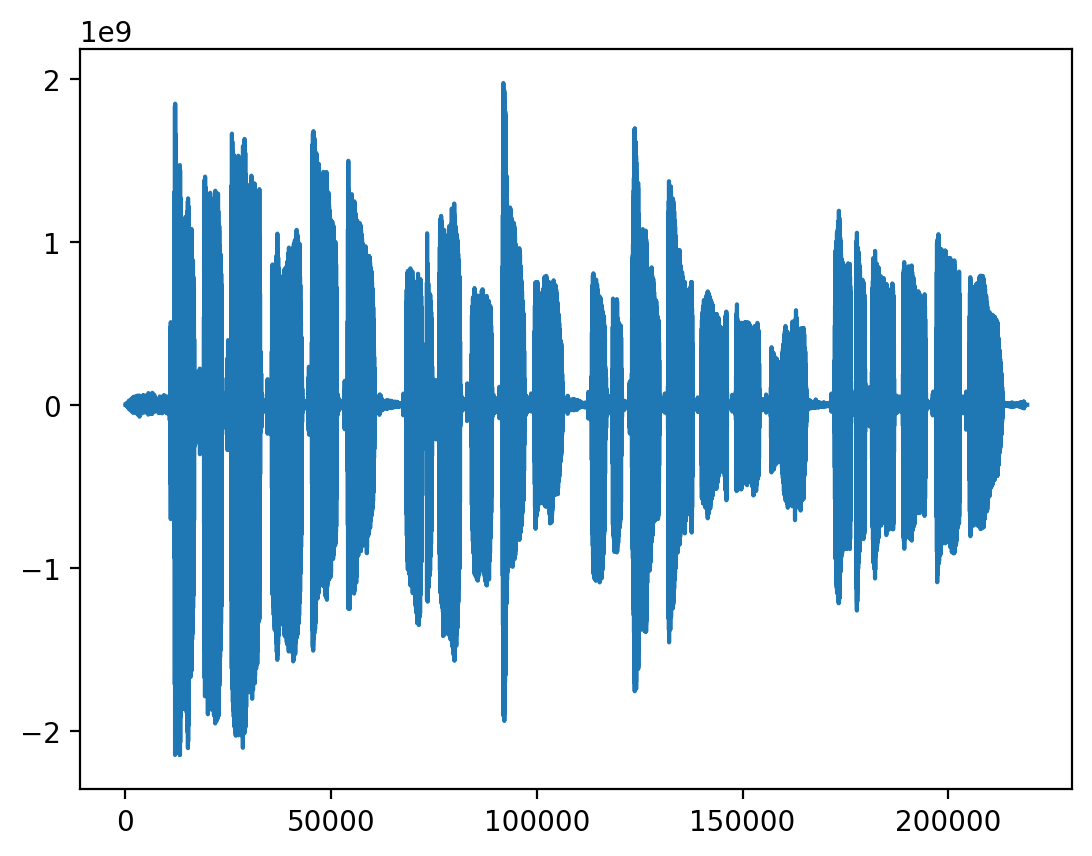

In [142]:
#saanvi
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

In [143]:
#saanvi
# normalizing to floats
MAX_ABS_INT16 = 32768.0
audio_samples = audio_samples / float(MAX_ABS_INT16)

In [144]:
#saanvi
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

In [161]:
#saanvi
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]
indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)
for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.93  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

In [162]:
#saanvi
# turning frequencies into note names

def getNotesFromArray(input_array):
    lines = input_array
    pitch_outputs = []
    for line in lines:
        pitch_outputs.append(float(line))
    note_list = []
    note_file = open("NOTES_"+ uploaded_file_name, "w")
    for i in range(len(pitch_outputs)):
        ideal_offset = 0
        note_list.append(quantize_predictions(ideal_offset, pitch_outputs[i]))
        # note_list.append(quantize_predictions(ideal_offset, pitch_outputs[i]))
        note_file.write(note_list[i]+"\n")
    print(note_list)
    for n in note_list:
      list_of_notes.append(n)


A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
list_of_notes = []
def quantize_predictions(ideal_offset, freq):
    h = round(12 * math.log2(freq / C0))
    # test cases outside
    # h = round(12 * math.log2(freq / C0) - ideal_offset)
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    return note

getNotesFromArray(confident_pitch_values_hz)



['C4', 'C#4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B3', 'C#4', 'C#4', 'C#4', 'C#4', 'C4', 'C4', 'C#4', 'C4', 'B3', 'D#4', 'D#4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'B3', 'C4', 'C4', 'C4', 'B3', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B3', 'F#4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F#4', 'F4', 'F4', 'F4', 'F4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'F4', 'B3', 'C4', 'C4', 'C4', 'C#4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C#4', 'C#4', 'C#4', 'C4', 'B3', 'D#4', 'D#4', 'D#4', 'D#4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'C#4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C#4', 'C4', 'G4', 'G4', 'G4', 'F#4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'F4', 'C4', 'C4', 'C4', 'C#4', 'C4', 'C4', 'C4', 'C4', 'B3', 'C4', 'C#4', 'C#4', 'C#4', 'C#4', 'C#4', 'C5', 'C#5', 'C#5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5'

In [163]:
#saanvi
# turning note names into midi numbers
#21 is A0 33 is A1 etc
note_midi_nums = []
new_note_names = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
for x in range(len(list_of_notes)):
  temp_list = [*list_of_notes[x]]
  i = 0
  if (len(temp_list)) == 2:
    i = new_note_names.index(temp_list[0])
  else:
    s = temp_list[0] + temp_list[1]
    i = new_note_names.index(s)

  note_midi_nums.append((21 + (int(temp_list[-1])-1)*12 + i))

print(note_midi_nums)

[60, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 47, 61, 61, 61, 61, 60, 60, 61, 60, 47, 63, 63, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 47, 60, 60, 60, 47, 60, 60, 60, 60, 60, 60, 60, 60, 60, 47, 66, 65, 65, 65, 65, 65, 65, 66, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 47, 60, 60, 60, 61, 60, 60, 60, 60, 60, 61, 61, 61, 60, 47, 63, 63, 63, 63, 62, 62, 62, 62, 62, 62, 62, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 60, 67, 67, 67, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 60, 60, 60, 61, 60, 60, 60, 60, 47, 60, 61, 61, 61, 61, 61, 72, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 68, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 65, 65, 64, 64, 61, 62, 62, 62, 61, 61, 62, 63, 63, 63, 62, 62, 63, 62, 62, 62, 62, 63, 63, 63, 58, 58, 58, 58, 58, 58, 58, 58, 58, 57, 59, 58, 58, 58, 58, 58, 58, 58, 58,

In [156]:
#saanvi
# remove all repeating notes
i = 1
while i < len(note_midi_nums):
  if (note_midi_nums[i] == note_midi_nums[i-1]):
    del note_midi_nums[i]
  else:
    i+=1
print(note_midi_nums)


[44, 60, 61, 60, 47, 61, 60, 61, 60, 47, 63, 62, 47, 60, 47, 60, 47, 66, 65, 66, 65, 66, 65, 64, 65, 47, 60, 61, 60, 61, 60, 47, 63, 62, 61, 60, 61, 60, 67, 66, 67, 65, 66, 65, 47, 60, 61, 60, 47, 60, 61, 72, 73, 72, 68, 57, 66, 65, 66, 65, 64, 65, 64, 61, 62, 61, 62, 63, 62, 63, 62, 63, 35, 58, 57, 59, 58, 57, 66, 65, 66, 65, 64, 68, 67, 65, 66, 65, 66]


In [157]:
#daniel
# use only intervals
note_midi_intervals = []
for i in range(len(note_midi_nums)-1):
  note_midi_intervals.append(note_midi_nums[i + 1] - note_midi_nums[i])

i = 0
print(note_midi_intervals)
while i < len(note_midi_intervals):
  if (note_midi_intervals[i] == -1 or note_midi_intervals[i] == 1):
    del note_midi_intervals[i]
  else:
    i+=1
print(note_midi_intervals)
# [2, -2, 5, -1, -4, 2, -2, 7, -2, -5, 12, -3, -4, -1, -2, 8, -1, -4, 2, -2]

[16, 1, -1, -13, 14, -1, 1, -1, -13, 16, -1, -15, 13, -13, 13, -13, 19, -1, 1, -1, 1, -1, -1, 1, -18, 13, 1, -1, 1, -1, -13, 16, -1, -1, -1, 1, -1, 7, -1, 1, -2, 1, -1, -18, 13, 1, -1, -13, 13, 1, 11, 1, -1, -4, -11, 9, -1, 1, -1, -1, 1, -1, -3, 1, -1, 1, 1, -1, 1, -1, 1, -28, 23, -1, 2, -1, -1, 9, -1, 1, -1, -1, 4, -1, -2, 1, -1, 1]
[16, -13, 14, -13, 16, -15, 13, -13, 13, -13, 19, -18, 13, -13, 16, 7, -2, -18, 13, -13, 13, 11, -4, -11, 9, -3, -28, 23, 2, 9, 4, -2]
